In [1]:
log_id = "CAN_2023-09-11(112931)"


In [2]:

import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import pandas as pd

from skn.query import Query
from skn.CAN.fields.channels import *
from skn.CAN.tags.tags import *


ModuleNotFoundError: No module named 'ipympl'

### Power utilization

In [22]:
power = Query().all_tags(Log_id(log_id)).channels(POWERLIMITING.MOTOR_EFF_ESTIMATED, POWERLIMITING.KERS_EFF_ESTIMATED, TSDATA.POWER).keep_columns(Lap).interpolate('100ms').execute().to_dataframe()
power = pd.DataFrame(power)
index = power[(power['lap'] =="ToStart") | (power['lap'] =="ToGarage") | (power['lap'] =="InPits")].index
power.drop(index , inplace=True)

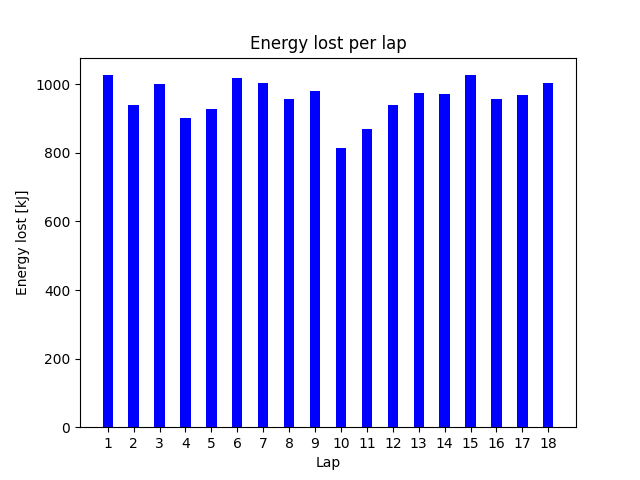

Total energy lost:  4.802 kWh


In [48]:
#Energy lost
energy_lost = []

for lap in range(1, max(power['lap'].astype(int))+1):
    power_lap = power.loc[power['lap'] == str(lap)] 
    if power_lap['TSData_power'].sum()*0.1/1000 > 50:
        energy_lost.append(power_lap['TSData_power'].sum()*0.1/1000) #Multiply with 0.1 because of 100ms interpolation

plt.figure()
plt.bar(np.arange(len(energy_lost)), energy_lost, color = 'b', width = 0.4)
plt.title('Energy lost per lap')
plt.xlabel('Lap')
plt.ylabel('Energy lost [kJ]')
plt.xticks(np.arange(len(energy_lost)), np.arange(1, len(energy_lost)+1))
plt.show()

print("Total energy lost: ", round(sum(energy_lost)/3600,3), "kWh")

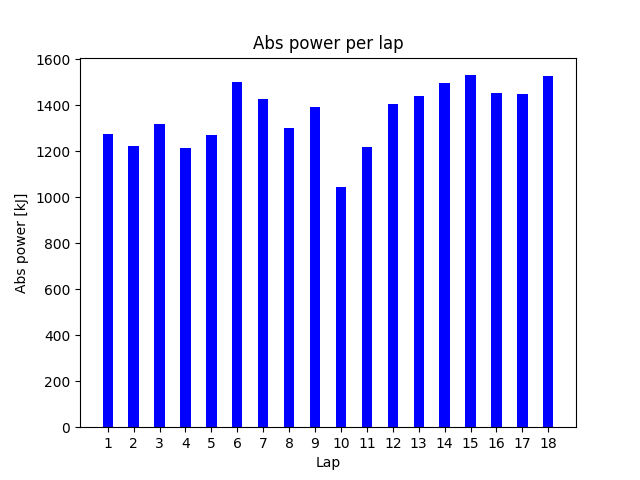

Total abs power:  6.802 kWh


In [49]:
#Abs power
abs_power = []
for lap in range(1, max(power['lap'].astype(int))+1):
    
    power_lap = power.loc[power['lap'] == str(lap)]
    if power_lap['TSData_power'].abs().sum()*0.1/1000 > 50:
        abs_power.append(power_lap['TSData_power'].abs().sum()*0.1/1000) #Multiply with 0.1 because of 100ms interpolation
        
plt.figure()
plt.bar(np.arange(len(abs_power)), abs_power, color = 'b', width = 0.4)
plt.title('Abs power per lap')
plt.xlabel('Lap')
plt.ylabel('Abs power [kJ]')
plt.xticks(np.arange(len(abs_power)), np.arange(1, len(abs_power)+1))
plt.show()

print("Total abs power: ", round(sum(abs_power)/3600,3), "kWh")

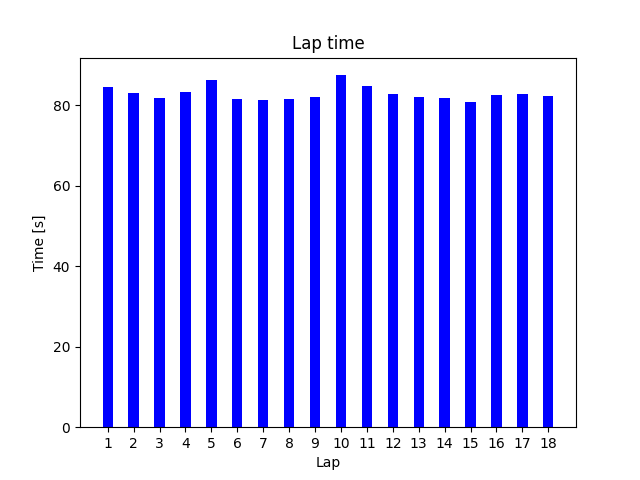

In [51]:
#Lap time
lap_times = []
for laps in range(1, max(power['lap'].astype(int))+1):
    lap = power.loc[power['lap'] == str(laps)]
    if lap['time'].iloc[-1] - lap['time'].iloc[0] < 100:
        lap_times.append(lap['time'].iloc[-1] - lap['time'].iloc[0])

plt.figure()
plt.bar(np.arange(len(lap_times)), lap_times, color = 'b', width = 0.4)
plt.title('Lap time')
plt.xlabel('Lap')
plt.ylabel('Time [s]')
plt.xticks(np.arange(len(lap_times)), np.arange(1, len(lap_times)+1))
plt.show()

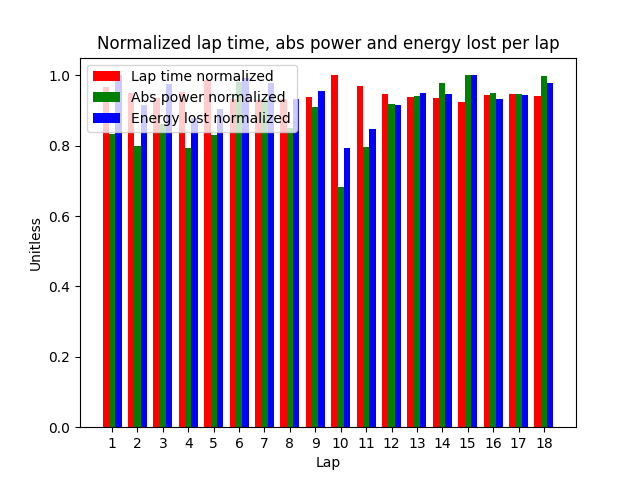

In [50]:

barWidth = 0.25
br1 = np.arange(len(lap_times))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.figure()
plt.bar(br1, lap_times/max(lap_times), color = 'r', width = barWidth, label = 'Lap time normalized')
plt.bar(br2, abs_power/max(abs_power), color = 'g', width = barWidth, label = 'Abs power normalized')
plt.bar(br3, energy_lost/max(energy_lost), color = 'b', width = barWidth, label = 'Energy lost normalized')

plt.title('Normalized lap time, abs power and energy lost per lap')
plt.xlabel('Lap')
plt.ylabel('Unitless')
plt.xticks([r + barWidth for r in range(len(lap_times))], np.arange(1, len(lap_times)+1))

plt.legend()
plt.show()
    

### Accu temp + SoC

In [76]:
Accu = Query().all_tags(Log_id(log_id)).channels(STATEOFCHARGE.SOC, METADATA.MAX_TEMP_VALUE).keep_columns(Lap).interpolate('100ms').execute().to_dataframe()
Accu = pd.DataFrame(Accu)
index = Accu[ (Accu['lap'] =="ToStart") | (Accu['lap'] =="ToGarage") | (Accu['lap'] =="InPits")].index
Accu.drop(index , inplace=True)


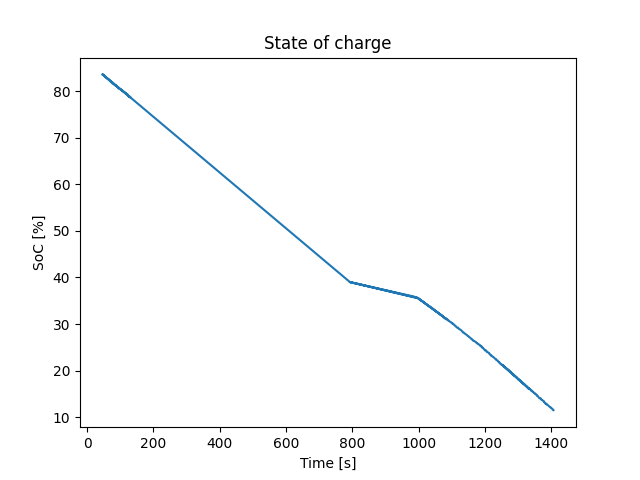

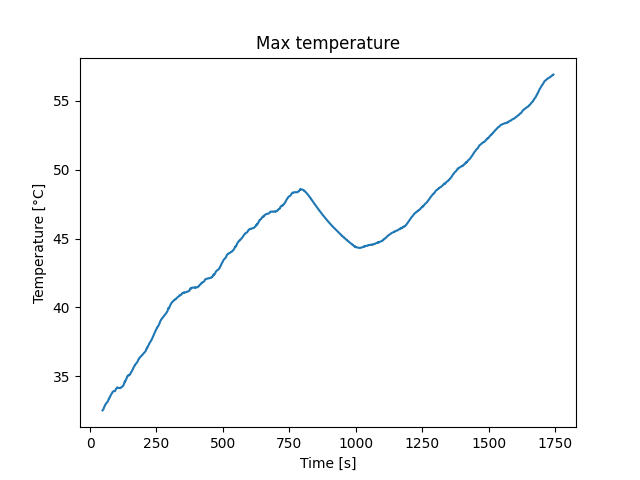

In [80]:
#SoC
plt.figure()
#plt.plot(Accu['time'][1:-10000], Accu['StateOfCharge_soc'][1:-10000])
plt.plot(Accu['time'], Accu['StateOfCharge_soc'])
plt.title('State of charge')
plt.xlabel('Time [s]')
plt.ylabel('SoC [%]')
plt.show()

#Temperature
plt.figure()
plt.plot(Accu['time'], Accu['Metadata_max_temp_value'])
# plt.plot(Accu['time'][1:-500], Accu['Metadata_max_temp_value'][1:-500])
plt.title('Max temperature')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.show()

### KERS Upramper

In [97]:
Upramper = Query().all_tags(Log_id(log_id)).channels(TSDATA.POWER, POWERLIMITING.MAX_KERS_POWER, POWERLIMITING.VOLTAGE_TREND, METADATA.MAX_VOLTAGE_VALUE, TSDATA.VOLTAGE_TOTAL_SUM_OF_CELLS\
                                                     ).keep_columns(Lap).interpolate('100ms').execute().to_dataframe()
Upramper = pd.DataFrame(Upramper)
index = Upramper[ (Upramper['lap'] =="ToStart") | (Upramper['lap'] =="ToGarage") | (Upramper['lap'] =="InPits")].index
Upramper.drop(index , inplace=True)

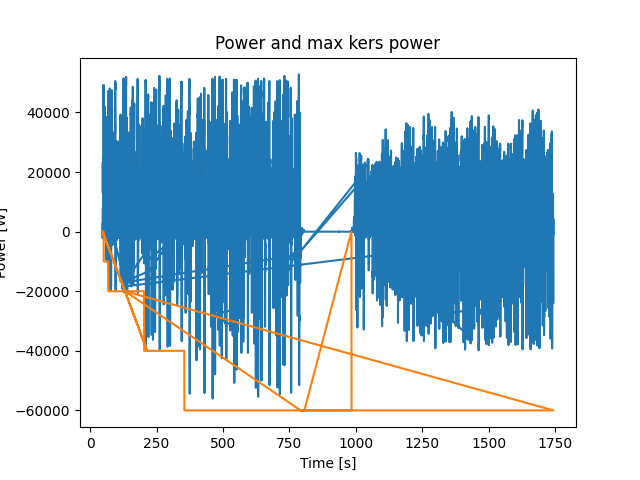

In [98]:
#Powerlimiting
plt.figure()
plt.plot(Upramper['time'], Upramper['TSData_power'])
plt.plot(Upramper['time'], Upramper['PowerLimiting_max_kers_power'])
plt.title('Power and max kers power')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.show()

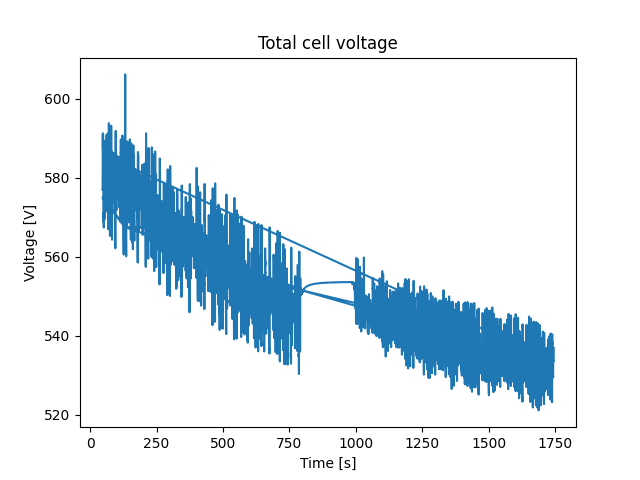

In [99]:
#Total cell voltage
plt.figure()
plt.plot(Upramper['time'], Upramper['TSData_voltage_total_sum_of_cells'])
plt.title('Total cell voltage')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.show()

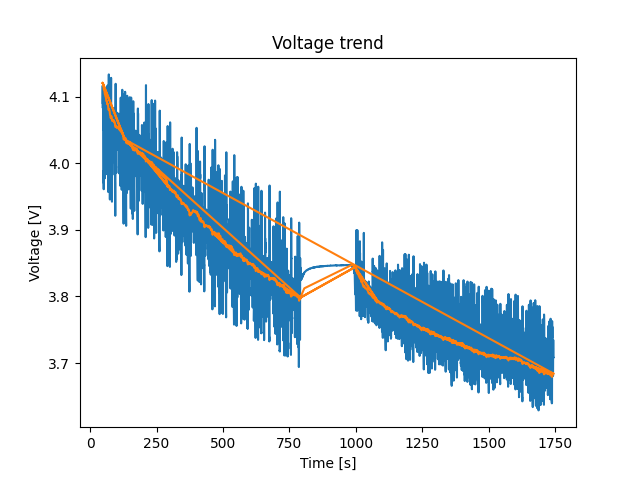

In [101]:
#Voltage trend
plt.figure()
plt.plot(Upramper['time'], Upramper['Metadata_max_voltage_value'])
plt.plot(Upramper['time'], Upramper['PowerLimiting_voltage_trend'])
plt.title('Voltage trend')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.show()

### Motor + Gear

In [82]:
Inwheel = Query().all_tags(Log_id(log_id)).channels(MECHANICAL.SPEED_FL, MECHANICAL.SPEED_FR, MECHANICAL.SPEED_RL, MECHANICAL.SPEED_RR, \
                                                    MECHANICAL.TORQUE_FL, MECHANICAL.TORQUE_FR, MECHANICAL.TORQUE_RL, MECHANICAL.TORQUE_RR,\
                                                        TEMPERATURES.MOTOR_TEMP_FL, TEMPERATURES.MOTOR_TEMP_FR, TEMPERATURES.MOTOR_TEMP_RL, TEMPERATURES.MOTOR_TEMP_RR, \
                                                            GEARTEMPERATUREFRONT.LEFT, GEARTEMPERATUREFRONT.RIGHT, GEARTEMPERATUREREAR.LEFT, GEARTEMPERATUREREAR.RIGHT\
                                                                ).keep_columns(Lap).interpolate('100ms').execute().to_dataframe()
Inwheel = pd.DataFrame(Inwheel)
index = Inwheel[ (Inwheel['lap'] =="ToStart") | (Inwheel['lap'] =="ToGarage") | (Inwheel['lap'] =="InPits")].index
Inwheel.drop(index , inplace=True)

Text(0.5, 1.0, 'Gear temperature')

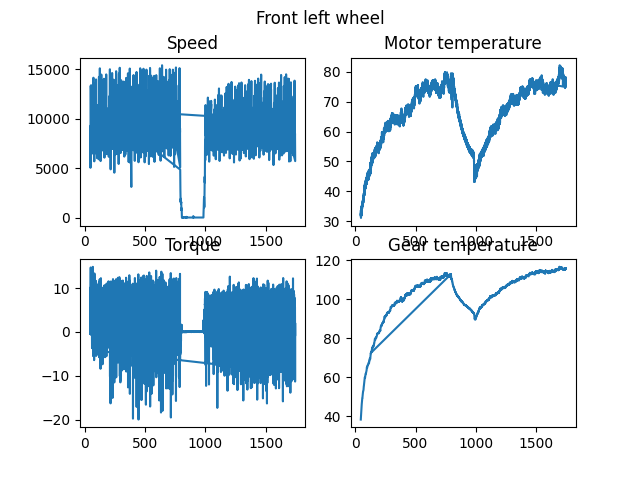

In [93]:

#Front left
fig, axs = plt.subplots(2, 2)
fig.suptitle('Front left wheel')
axs[0, 0].plot(Inwheel['time'], Inwheel['Mechanical_speed_fl'])
axs[0, 0].set_title('Speed')
axs[1, 0].plot(Inwheel['time'], Inwheel['Mechanical_torque_fl'])
axs[1, 0].set_title('Torque')
axs[0, 1].plot(Inwheel['time'], Inwheel['Temperatures_motor_temp_fl'])
axs[0, 1].set_title('Motor temperature')
axs[1, 1].plot(Inwheel['time'], Inwheel['GearTemperatureFront_left'])
axs[1, 1].set_title('Gear temperature')


Text(0.5, 1.0, 'Gear temperature')

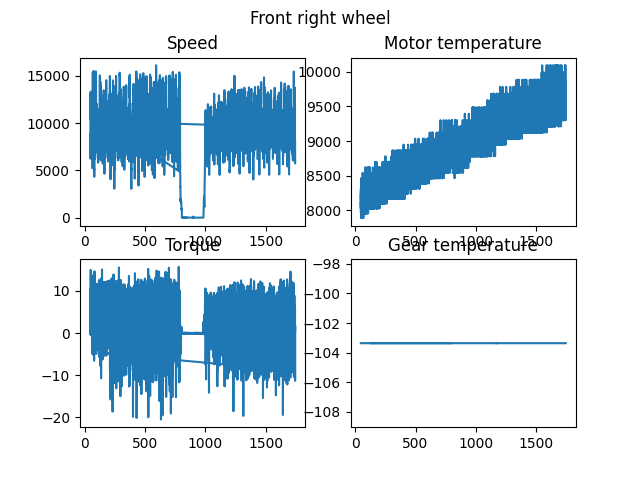

In [94]:
#Front right
fig, axs = plt.subplots(2, 2)
fig.suptitle('Front right wheel')
axs[0, 0].plot(Inwheel['time'], Inwheel['Mechanical_speed_fr'])
axs[0, 0].set_title('Speed')
axs[1, 0].plot(Inwheel['time'], Inwheel['Mechanical_torque_fr'])
axs[1, 0].set_title('Torque')
axs[0, 1].plot(Inwheel['time'], Inwheel['Temperatures_motor_temp_fr'])
axs[0, 1].set_title('Motor temperature')
axs[1, 1].plot(Inwheel['time'], Inwheel['GearTemperatureFront_right'])
axs[1, 1].set_title('Gear temperature')


Text(0.5, 1.0, 'Gear temperature')

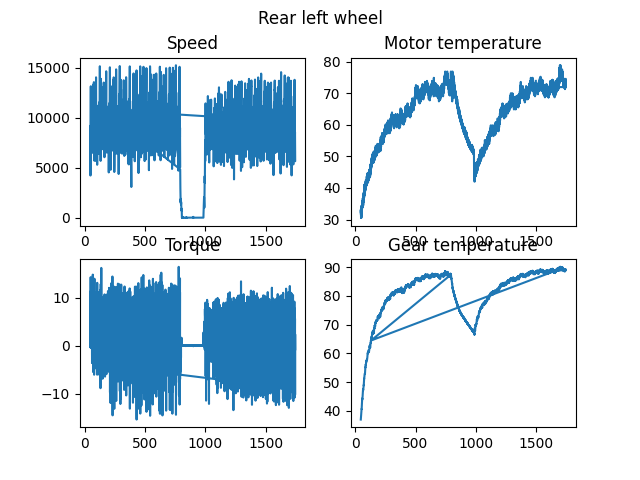

In [95]:
#Rear left
fig, axs = plt.subplots(2, 2)
fig.suptitle('Rear left wheel')
axs[0, 0].plot(Inwheel['time'], Inwheel['Mechanical_speed_rl'])
axs[0, 0].set_title('Speed')
axs[1, 0].plot(Inwheel['time'], Inwheel['Mechanical_torque_rl'])
axs[1, 0].set_title('Torque')
axs[0, 1].plot(Inwheel['time'], Inwheel['Temperatures_motor_temp_rl'])
axs[0, 1].set_title('Motor temperature')
axs[1, 1].plot(Inwheel['time'], Inwheel['GearTemperatureRear_left'])
axs[1, 1].set_title('Gear temperature')

Text(0.5, 1.0, 'Gear temperature')

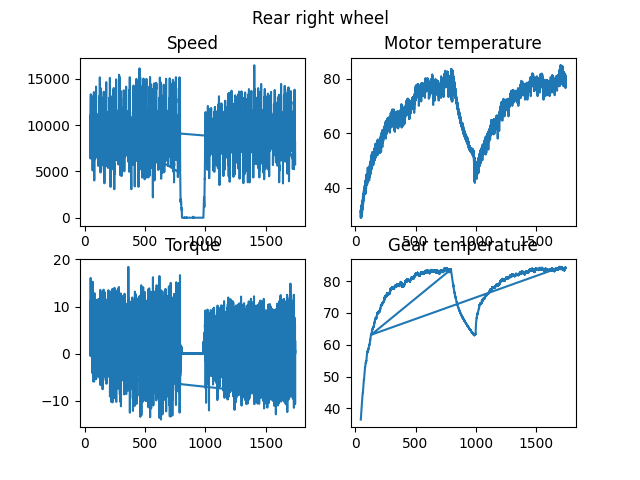

In [96]:
#Rear right
fig, axs = plt.subplots(2, 2)
fig.suptitle('Rear right wheel')
axs[0, 0].plot(Inwheel['time'], Inwheel['Mechanical_speed_rr'])
axs[0, 0].set_title('Speed')
axs[1, 0].plot(Inwheel['time'], Inwheel['Mechanical_torque_rr'])
axs[1, 0].set_title('Torque')
axs[0, 1].plot(Inwheel['time'], Inwheel['Temperatures_motor_temp_rr'])
axs[0, 1].set_title('Motor temperature')
axs[1, 1].plot(Inwheel['time'], Inwheel['GearTemperatureRear_right'])
axs[1, 1].set_title('Gear temperature')